In [259]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [260]:
# Code configuration
SOURCE_IMAGE_PATH = "inputImages/fiddji.jpg"
OUTPUT_IMAGE_PATH = "output.jpg"
YOLO_FOLDER_PATH = "yoloFiles"
USE_WEBCAM = False  # Switch to True to take a picture from the default webcam instead of source image
LINE_THICKNESS_RATIO = 600  # Adjust the ratio if the lines are too/not enough thick

In [261]:
# Load YOLO (You Only Look Once) weights and configuration
yolo_net = cv2.dnn.readNet(f"{YOLO_FOLDER_PATH}/yolov3.weights", f"{YOLO_FOLDER_PATH}/yolov3.cfg")

# Load the classes from the coco.names file
with open(f"{YOLO_FOLDER_PATH}/coco.names", "r") as file:
    class_names = [line.strip() for line in file.readlines()]

# Get the names of all layers in the network
layer_names = yolo_net.getLayerNames()

# Get the names of the output layers
output_layers = [layer_names[i - 1] for i in yolo_net.getUnconnectedOutLayers()]

In [262]:
image = None

if USE_WEBCAM:
    # Initialize the webcam (assuming it's the default webcam, usually index 0)
    cap = cv2.VideoCapture(0)

    # Check if the webcam is opened successfully
    if not cap.isOpened():
        print("Error: Unable to access the webcam.")
    else:
        # Capture a single frame from the webcam
        ret, frame = cap.read()

        # Check if the frame is captured successfully
        if not ret:
            print("Error: Unable to capture frame from the webcam.")
        else:
            image = frame

    cap.release()

In [263]:
if not USE_WEBCAM:
    # Load the source image

    image = cv2.imread(SOURCE_IMAGE_PATH)

# Get the dimensions
height, width, channels = image.shape

In [264]:
# Calculate thickness ratio based on image dimensions
thickness_ratio = int((height + width) / LINE_THICKNESS_RATIO)

# Detect objects in the resized image
blob = cv2.dnn.blobFromImage(image, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
yolo_net.setInput(blob)
outputs = yolo_net.forward(output_layers)

In [265]:
# Initialize lists to store detected object information
detected_class_ids = []
detected_confidences = []
detected_boxes = []

# Iterate through each set of detections
for output in outputs:
    for detection in output:
        # Extract class scores
        scores = detection[5:]
        # Get the index of the class with the highest score
        class_id = np.argmax(scores)
        # Get the confidence score of the detected class
        confidence = scores[class_id]

        # Check if the detected object's confidence is under the threshold
        if confidence < 0.5:
            continue

        # Calculate coordinates of the detected object
        center_x = int(detection[0] * width)
        center_y = int(detection[1] * height)
        box_width = int(detection[2] * width)
        box_height = int(detection[3] * height)

        # Calculate bounding box coordinates
        x = int(center_x - box_width / 2)
        y = int(center_y - box_height / 2)

        # Store the detected object's information
        detected_boxes.append([x, y, box_width, box_height])
        detected_confidences.append(float(confidence))
        detected_class_ids.append(class_id)

# Perform non-maximum suppression to remove overlapping bounding boxes
indexes = cv2.dnn.NMSBoxes(detected_boxes, detected_confidences, score_threshold=0.5, nms_threshold=0.4)

In [266]:
# Iterate through each detected bounding box
for i, detected_box in enumerate(detected_boxes):
    # Check if the current bounding box index is in the indexes after non-maximum suppression
    if i not in indexes:
        continue
    # Extract bounding box coordinates
    x, y, w, h = detected_box
    # Get the label of the detected object
    label = str(class_names[detected_class_ids[i]])

    # Draw bounding box rectangle
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), thickness_ratio)

    # Draw label text
    cv2.putText(image, label, (x, y + 30), cv2.FONT_HERSHEY_PLAIN, thickness_ratio * 2, (0, 255, 0), thickness_ratio)

# Save the annotated image
cv2.imwrite(OUTPUT_IMAGE_PATH, image)

True

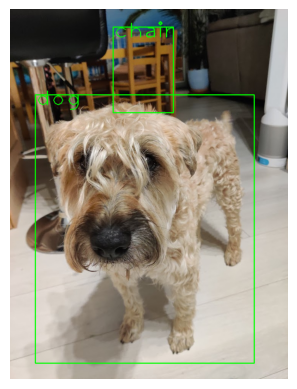

In [267]:
# Convert BGR to RGB (for matplotlib display)
output_image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image using matplotlib
plt.imshow(output_image_rgb)
plt.axis('off')  # Turn off axis labels
plt.show()